# Artificial Neural Networks, another atempt

Here I will try to make a neural network using numpy, that is capable of achieving a satisfying accuracy on the mnist dataset of handwritten digits. The model will be supervised and later I will give a potential unsupervised model for solving the same task which (hopefully) yields results similar to the supervised model


## Import necessary utility libraries


In [318]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

from matplotlib.pyplot import figure
from progress.bar import Bar

## Define utility functions

In [319]:
# Clamp value of matrix between 0 and 1
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Return an array with one at index of input integer
def one_hot_encode(x, size = 10):
    arr = np.zeros((size,1))
    arr[x] = 1
    return arr

# Drop neurons from layer with p chance
def layer_dropout(x, p = 0.3):
    
    if p == 0:
        return x
    
    layer = np.ones_like(x)
    drops = np.random.choice(
    np.arange(layer.size),
    replace = False,
    size = int(layer.size * p))
    
    layer[drops] = 0
    
    return np.multiply(x, layer)


# displayMe will show an image of the activations to display the networks accuracy.
# Does not work if the number of neurons in a givn layer is not a perfect square
def displayMe(signals, title, sizes):
    
    num = 191
    plt.subplots(figsize=(30,3))
    print()
    for i in range(len(signals)):
        if(sizes[i] == 10):
                # Print max of signal in layer
            print("signal in 10 neuron layer: ", np.argmax(signals[i]))
            continue
        plt.subplot(num)
        num += 1
        dim_int = int(math.sqrt(sizes[i]))
        dim = (dim_int, dim_int)
        plt.imshow(signals[i].reshape(dim))    

    plt.suptitle("Summed error: " + str(title))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

    plt.show()
    
    

## Activation Functions

In [320]:
def identity(x, d = False):
    if d == False:
        return x
    else:
        ones = np.ones(x.shape)
        return ones
    
def sgn(x, d = False):
    if d == False:
        return np.where(x < 0, -1, 1)
    else:
        return np.where(x != 0, 0, 0)
    
def l_relu(x, d = False):
    if not d:
        return np.where(x > 0, x, x/10)
    else:
        return np.where(x > 0, 1, -1.0/10)

def relu(x, d = False):
    if not d:
        return np.where(x > 0, x, 0)
    else:
        return np.where(x > 0, 1, 0)
    
def sigmoid(x, d = False):
    s = 1. / (1. + np.exp(-x))
    if not d:
        return s
    else:
        return np.multiply(s, (1 - s))

def tanh(x, d = False):
    th = np.tanh(x)
    if not d:
        return th
    else:
        return  1 - np.power(th, 2)

# Reverse relu
def r_relu(x, d = False):
    if not d:
        return np.where(x < 0, x, 0)
    else:
        return np.where(x < 0, 1, 0)
    
def lr_relu(x, d = False):
    if not d:
        return np.where(x < 0, x, x/10)
    else:
        return np.where(x < 0, 1, 1.0/10)

def softmax(x, d = False):
    if not d:
        e = np.exp(x - np.max(x))
        return e / np.sum(e)
    else:
        return np.sum()
    
# This function should return the biggest element(s) in a one hot encoded vector
def pivot_squeezer(x, d = False):
    b = np.zeros_like(one_hot_encode(0, size = len(x)))
    for i in np.argwhere(x == np.max(x)):
        b = np.add(b, one_hot_encode(i[0], size=len(x)))
    if not d:
        return b
    else:
        return np.where(b < 1, -0.1, 1)

### Plots
We can now plot the functions to see how they work

[-5 -4 -3 -2 -1  0  1  2  3  4] 

   ReLu   
[0 0 0 0 0 0 1 2 3 4]
[0 0 0 0 0 0 1 1 1 1]


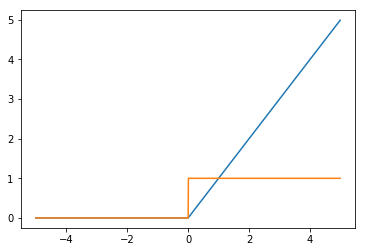

   identity   
[-5 -4 -3 -2 -1  0  1  2  3  4]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 



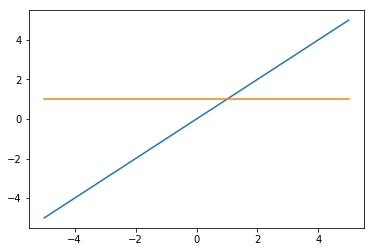

   l_ReLu   
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   1.   2.   3.   4. ]
[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1  1.   1.   1.   1. ] 



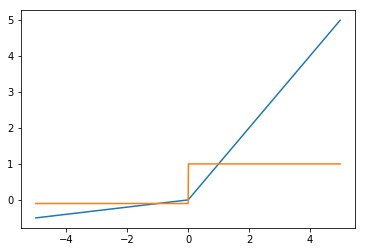

   Sigmoid   
[0.00669285 0.01798621 0.04742587 0.11920292 0.26894142 0.5
 0.73105858 0.88079708 0.95257413 0.98201379]
[0.00664806 0.01766271 0.04517666 0.10499359 0.19661193 0.25
 0.19661193 0.10499359 0.04517666 0.01766271] 



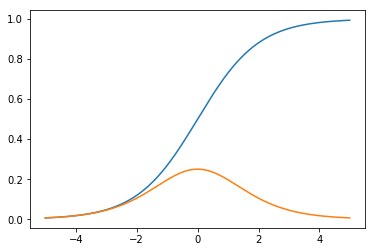

   sgn   
[-1 -1 -1 -1 -1  1  1  1  1  1]
[0 0 0 0 0 0 0 0 0 0] 



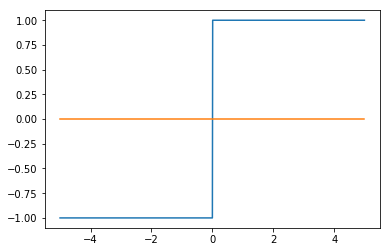

   TanH   
[-0.9999092  -0.9993293  -0.99505475 -0.96402758 -0.76159416  0.
  0.76159416  0.96402758  0.99505475  0.9993293 ]
[1.81583231e-04 1.34095068e-03 9.86603717e-03 7.06508249e-02
 4.19974342e-01 1.00000000e+00 4.19974342e-01 7.06508249e-02
 9.86603717e-03 1.34095068e-03] 



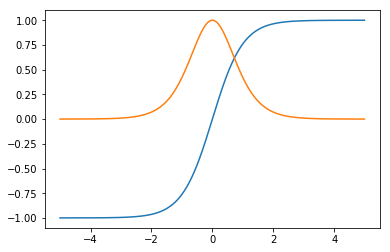

   Reverse ReLu   
[-5 -4 -3 -2 -1  0  0  0  0  0]
[1 1 1 1 1 0 0 0 0 0] 



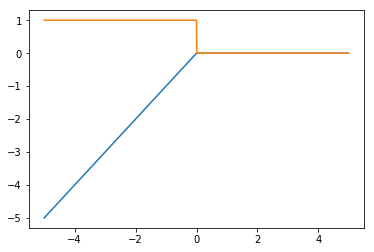

   Leaky Reverse ReLu   
[-5.  -4.  -3.  -2.  -1.   0.   0.1  0.2  0.3  0.4]
[1.  1.  1.  1.  1.  0.1 0.1 0.1 0.1 0.1] 



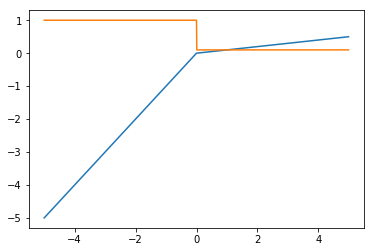

   Softmax   
[7.80134161e-05 2.12062451e-04 5.76445508e-04 1.56694135e-03
 4.25938820e-03 1.15782175e-02 3.14728583e-02 8.55520989e-02
 2.32554716e-01 6.32149258e-01]


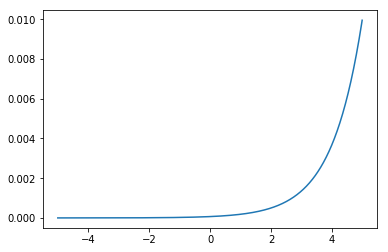

   Pivot Squeezer   
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]
[[-0.1]
 [-0.1]
 [-0.1]
 [-0.1]
 [-0.1]
 [-0.1]
 [-0.1]
 [-0.1]
 [-0.1]
 [ 1. ]] 



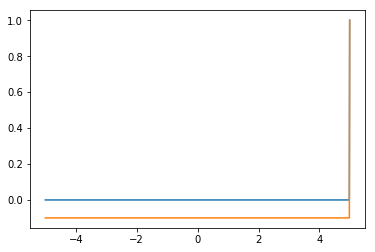

In [321]:
t = np.arange(-5, 5, step = 1)
t_prim = np.arange(-5, 5, step = 0.01)
print(t, "\n")

print("   ReLu   ")
print(relu(t))
print(relu(t, d = True))
plt.plot(t_prim, relu(t_prim))
plt.plot(t_prim, relu(t_prim, d = True))
plt.show()

print("   identity   ")
print(identity(t))
print(identity(t, d = True), "\n")
plt.plot(t_prim, identity(t_prim))
plt.plot(t_prim, identity(t_prim, d = True))
plt.show()

print("   l_ReLu   ")
print(l_relu(t))
print(l_relu(t, d = True), "\n")
plt.plot(t_prim, l_relu(t_prim))
plt.plot(t_prim, l_relu(t_prim, d = True))
plt.show()

print("   Sigmoid   ")
print(sigmoid(t))
print(sigmoid(t, d = True), "\n")
plt.plot(t_prim, sigmoid(t_prim))
plt.plot(t_prim, sigmoid(t_prim, d = True))
plt.show()

# NOT A GOOD CHOICE!
print("   sgn   ")
print(sgn(t))
print(sgn(t, d = True), "\n")
plt.plot(t_prim, sgn(t_prim))
plt.plot(t_prim, sgn(t_prim, d = True))
plt.show()


print("   TanH   ")
print(tanh(t))
print(tanh(t, d = True), "\n")
plt.plot(t_prim, tanh(t_prim))
plt.plot(t_prim, tanh(t_prim, d = True))
plt.show()

print("   Reverse ReLu   ")
print(r_relu(t))
print(r_relu(t, d = True), "\n")
plt.plot(t_prim, r_relu(t_prim))
plt.plot(t_prim, r_relu(t_prim, d = True))
plt.show()

print("   Leaky Reverse ReLu   ")
print(lr_relu(t))
print(lr_relu(t, d = True), "\n")
plt.plot(t_prim, lr_relu(t_prim))
plt.plot(t_prim, lr_relu(t_prim, d = True))
plt.show()

print("   Softmax   ")
print(softmax(t))
#print(softmax(t, d = True), "\n")
plt.plot(t_prim, softmax(t_prim))
#plt.plot(t_prim, softmax(t_prim, d = True))
plt.show()

print("   Pivot Squeezer   ")
print(pivot_squeezer(t))
print(pivot_squeezer(t, d = True), "\n")
plt.plot(t_prim, pivot_squeezer(t_prim))
plt.plot(t_prim, pivot_squeezer(t_prim, d = True))
plt.show()

## Loss functions

In [322]:
def MSE(output, expected, d = False, d_out = None):
    if not d:
        error = np.square(expected - output)
        return np.nan_to_num(error)
    else:
        error = np.multiply(np.subtract(output, expected), (np.matrix(d_out)))
        return np.nan_to_num(error)


def MAE(output, expected, d = False, d_out = None):
    if not d:
        error = np.sum(np.matrix(np.absolute(expected - output)))
        return np.nan_to_num(error)
    else:
        error = np.multiply(np.subtract(expected, output), (np.matrix(d_out)))
        return np.nan_to_num(error)

## Import the MNIST dataset (handwritten digits)

In [323]:

import tensorflow as tf
mnist = tf.keras.datasets.mnist
(training_examples, training_labels),(test_examples, test_labels) = mnist.load_data()

lab_examples = training_examples

training_examples = normalize(training_examples)
test_examples = normalize(test_examples)

tf.__version__


'1.9.0'

In [324]:
"""
###
Split data into train and test sets
###
"""

num_train = len(training_examples)  # amount of training examples/labels

num_test = len(test_examples)   # amount of test examples/labels

img_len = np.prod((training_examples[0].shape))      # Number of pixels in image

img_dim = (int(math.sqrt(img_len)), int(math.sqrt(img_len))) # Image dimension



training_examples = normalize(np.reshape(training_examples, (num_train, img_len, 1)))
lab_examples = np.reshape(lab_examples, (num_train, img_len, 1))
test_examples = normalize(np.reshape(test_examples, (num_test, img_len, 1)))
print(training_examples.shape)


print("Number of training examples and test examples: ", num_train, ", ", num_test)
print("data dimensions: ", img_dim)
print("example dimension: ", training_examples[0].shape)


# One hot encode the labeled data
train_l_encoded = []
test_l_encoded = []
[train_l_encoded.append(one_hot_encode(x)) for x in training_labels]
[test_l_encoded.append(one_hot_encode(x)) for x in test_labels]
print(train_l_encoded[0])
print(training_labels[0])

# Validation set, take the last 10,000 examples for validation
validation_examples = training_examples[50000: 60000]
validation_labels = train_l_encoded[50000: 60000]

(60000, 784, 1)
Number of training examples and test examples:  60000 ,  10000
data dimensions:  (28, 28)
example dimension:  (784, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]
5


Display some training images: 


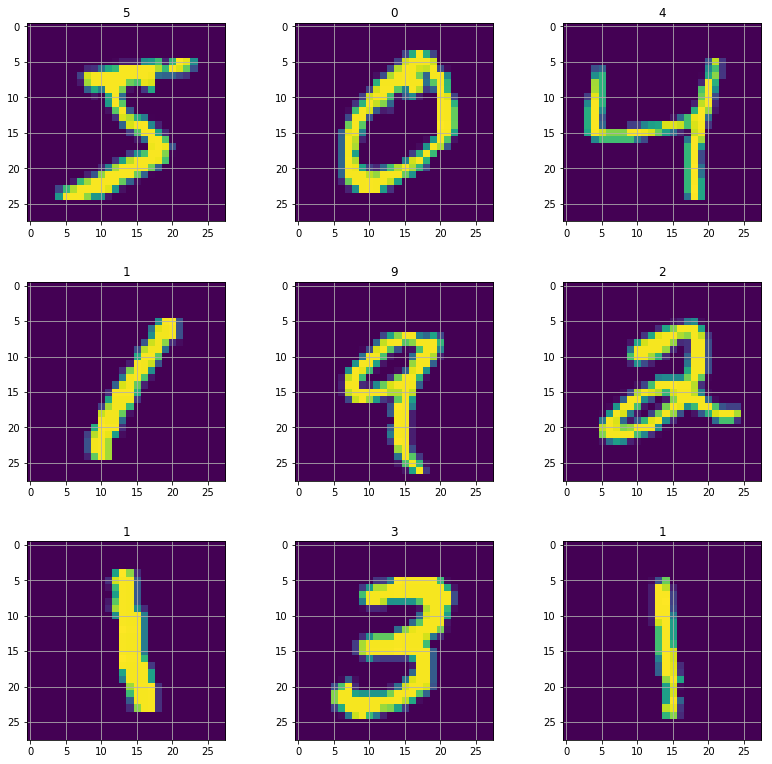

Training and testing distributions: 


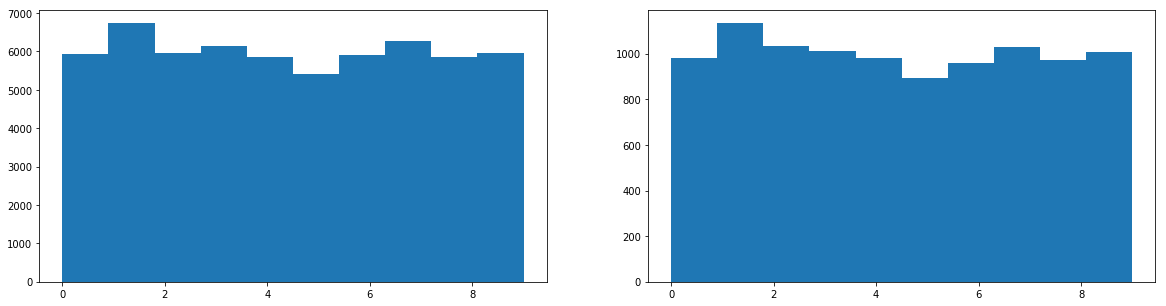

In [325]:
num = 331
display_imgs = training_examples[0:9]
print("Display some training images: ")
plt.subplots(figsize=(12,12))
for i in range(9):
    plt.subplot(num + i)
    plt.title(training_labels[i])
    plt.imshow(display_imgs[i].reshape(img_dim))    
    plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

print("Training and testing distributions: ")
plt.subplots(figsize= (20, 5))
plt.subplot(121)
plt.hist(training_labels)
plt.subplot(122)
plt.hist(test_labels)
plt.show()




# The neural network class

The network takes as input a list of sizes that determines the size of each layer(respective to each int) and a list of functions that work as activation functions for each layer relative to their order.



In [326]:
class NeuralNetwork:
    def __init__(self, sizes, activation_functions):
        
        self.sizes = sizes
        self.activation_functions = activation_functions
        
            # Generate random weights
        self.weights = list()
            # Set i + 1 to include bias term in weights
        [self.weights.append(np.random.random_sample((j, i + 1)) * math.sqrt(2/ (j*i)))
         for i, j in zip(self.sizes[:-1], self.sizes[1:])]


            # This is used during training to get the complete set of signals
    def feed_forward(self, input_vector, error_function = MSE, dropout = 0):
        
            # Gathered signals
        signals = []
        derived_signals = []

        input_vector = np.matrix(input_vector).reshape((input_vector.size, 1))
            # Append input as the first signal
        signals.append(layer_dropout(input_vector, p = dropout))

        derived_signals.append(self.activation_functions[0](input_vector, d = True))
        
            # For every combined weight matrix, activation function and bias
        for w, f in zip(self.weights[:-1], self.activation_functions[:-1]):
            
                # Append bias value to input vector
            signal = np.vstack((signals[-1], 1))
                # Save derivative of signal
            derived_signals.append(f(np.dot(w, signal), d = True))
                # Save the signal itself
            signals.append(layer_dropout(f(np.dot(w, signal), d = False), p = dropout))

            # Append bias value to input vector
        signal = np.vstack((signals[-1], 1))
            # Save derivative of signal
        derived_signals.append(self.activation_functions[-1](np.dot(self.weights[-1], signal), d = True))
            # Save the signal itself
        signals.append(self.activation_functions[-1](np.dot(self.weights[-1], signal), d = False))

            # Return 2 things: the signals, the derived signals
        return signals, derived_signals
    
    def backpropagate(self, signals, d_signals, out_error):

            # Error in each layer
        error_vectors = list() 
            # Gradient which will update the network
        gradient = list()
        
            # Append error in output layer
        output_error = np.multiply(out_error, d_signals[-1])
        error_vectors.append(output_error)
            
            #Note! We need to multiply our error by the signals leading into the output-layer
            #    We need this for updating is the gradient, which is just the derivative of the error
            #    multiplied by the input from the previous layer
            
            
        output_error = output_error * np.vstack((signals[-2], 1)).T
        gradient.append(output_error)
        
            
            #We now repeat the above with on big exception:
            #     We need to take the previous error into concideration by multiplying with it,
            #     the first error was achieved by our costfunction, every other error is derived from the
            #     previous one and so on.
            
        for w in reversed(range(1, len(self.weights))):
            
            # The error in each hidden layer = E * W * d_X
            #    Where W are the weights we want to change, E is the error in the previous layer
            #    and X is the derived input signals from this layer
            
                # This multiplication results in a vector of the form (1, n), 
                # because I wrote this algorithm with column vectors in mind,
                # The transpose (n, 1) is saved for the next iteration

            error = np.multiply(error_vectors[-1], self.weights[w][:, :-1])
            error = np.sum(np.multiply(error, d_signals[w].T), axis = 0)
            
            error_vectors.append(error.T)
            
                # The gradient is in this case a matrix in the same form as the respective weight matrix.
                # For this reason we multiply our transposed error (n, 1) by the transposed signal (1, m)
                # resulting in a (n,m) matrix, neglecting this will result in a redundant scalar
                
            error = error.T * np.vstack((signals[w - 1], 1)).T
            gradient.append(error)
            
                # The only necessary update is now to suntract each weight
                # from the learning rate(alpha) multiplied by the gradient
            
        return gradient
    
    def update_w(self, gradient, alpha):
        for w in range(len(self.weights)):
            self.weights[w] -= alpha * gradient[-(w + 1)]
            
    # Automate feed forwarding and backpropagation for briefer training-functions
    def propagate(self, inp, expected, error_function = MSE):
        
        signals, d_signals = self.feed_forward(inp)
        out_error = self.error_function(signals[-1], expected, d = True, d_out = d_signals[-1])
        
            # Will return the gradient of the error and the prediction on input
        return self.backpropagate(signals, d_signals, out_error), signals[-1]
    
    
    # Simple training for one example at a time
    def train(self, data, label, overfit = False, alpha = 0.1):
        sig = list()
        for d, l in zip(data, label):
            
            if overfit:
                d = data[0]
                l = label[0]
                
            gradient, prediction = self.propagate(d, l)
            
            self.update(gradient, alpha)
            sig.append(prediction)
    
    # Batch training, will update weights after each batch-example have been considered
    def train_on_batch(self, examples, labels, 
                       alpha = 0.01, 
                       dropout = 0,
                       vocal = False, 
                       error_function = MSE, 
                       lamb = 0.01, 
                       display_signals = False):
    
        grad = []
        [grad.append(np.zeros_like(i)) for i in reversed(self.weights)]

        predictions = []

        for e, l in zip(examples, labels):

            s, d = self.feed_forward(e, dropout = dropout)
            
            predictions.append(np.argmax(s[-1]))

            d_pred_error = error_function(s[-1], l, d = True, d_out = d[-1])
            g = self.backpropagate(s, d, d_pred_error)

            for i in range(len(grad)):
                
                grad[i] += (g[i] / len(examples)) + lamb/(2*len(examples)) * (self.weights[-(i + 1)])
        
        if display_signals:
            displayMe(s, np.sum(error_function(s[-1], l)), self.sizes)
                
        self.update_w(grad, alpha)

        if vocal:
            print(predictions[-1], "==", labels[-1])
            plt.title("Predictions")
            plt.hist(predictions, range = [0, 9])
            plt.show()

        err = error_function(s[-1], l)
        return err
    
    
    # Divide data into batches and start training
    def batch_training(self, examples, labels,
                       valid_examples = None, valid_labels = None,
                       test_examples = None, test_labels = None,
                       epochs = 1, 
                       alpha = 0.01, 
                       batch_size = 1,
                       dropout = 0,
                       reg_term = 0.1,
                       error_function = MSE, 
                       vocal = False, 
                       overfit = False, 
                       iters = 100, 
                       display_signals = False,
                       display_freq = 0):

        errs = []
        
        for e in range(epochs):
            
            display_frequency = 0
            
            if vocal == True:
                print("Epoch: ", e + 1 )
                print("Updates: ", int(len(examples) / batch_size))
            
            if overfit:
                for i in range(iters):
                    
                        # Show activation signals at set frequencies
                        
                    if display_frequency > display_freq:
                            display_frequency = 0
                            
                    display_frequency += 1
                
                    display_now = display_frequency == display_freq and display_signals
                    
                    e = self.train_on_batch(examples[0:1], 
                                            labels[0:1],
                                            dropout=dropout,
                                            vocal=False,
                                            lamb = reg_term,
                                            display_signals = display_now)
                    errs.append(np.sum(e))
                    
                    
            else:
                for i in range(int(len(examples) / batch_size)):
                        # Show activation signals at set frequencies
                    if display_frequency > display_freq:
                            display_frequency = 0
                            
                    display_frequency += 1
                                        
                    display_now = display_frequency == display_freq and display_signals
                    
                    e = self.train_on_batch(examples[i * batch_size: (i + 1) * batch_size],
                                            labels[i * batch_size: (i + 1) * batch_size],
                                            alpha = alpha,
                                            dropout = dropout,
                                            lamb = reg_term,
                                            display_signals = display_now)
                
                    errs.append(np.sum(e))
            
            if not valid_examples is None and not valid_labels is None:
                print("Validation Accuracy")
                self.test(valid_examples, valid_labels)

        print(max(errs), min(errs))
        plt.subplots(figsize=(30,20))
        plt.title("Error over iterations")
        plt.plot(errs)
        plt.show()
        
        if not test_examples is None and not test_labels is None:
            print("Test accuracy")
            self.test(test_examples, test_labels)

    def test(self, examples, labels):
        acc = 0

        predictions = []
        ls = []
        for e, l in zip(examples, labels):

            pred, d = self.feed_forward(e, dropout= 0)

            pred = np.argmax(pred[-1])
            l = np.argmax(l)
            predictions.append(pred)
            ls.append(l)
            
            if(pred == l):
                acc += 1
        
        print(acc, "/", len(examples))
        plt.title("Predictions")
        plt.hist([predictions, ls], label = ["prediction", "true_label"], color = ["cyan", "magenta"])
        plt.xticks(range(0, 9))
        plt.legend(loc = "upper right")
        plt.show()


# Using the model 

## Test if the network can learn basic operations like addition
For these examples, if the weights become optimal by assuming certain values.
For example: Adding the two numbers means that the weight simply must assume the value 1,
if the backprpagation algorithm is implemented correctly, then the weights should converge to 1
quickly (relative to the learning rate of course)


In [327]:
# Generate dummy data
t_e = [np.random.random_sample((2, 1)) + 50 for i in range(60000)]
l_e = [np.sum(e) for e in t_e]

4457.364347942511 1.3237757597267255e-10


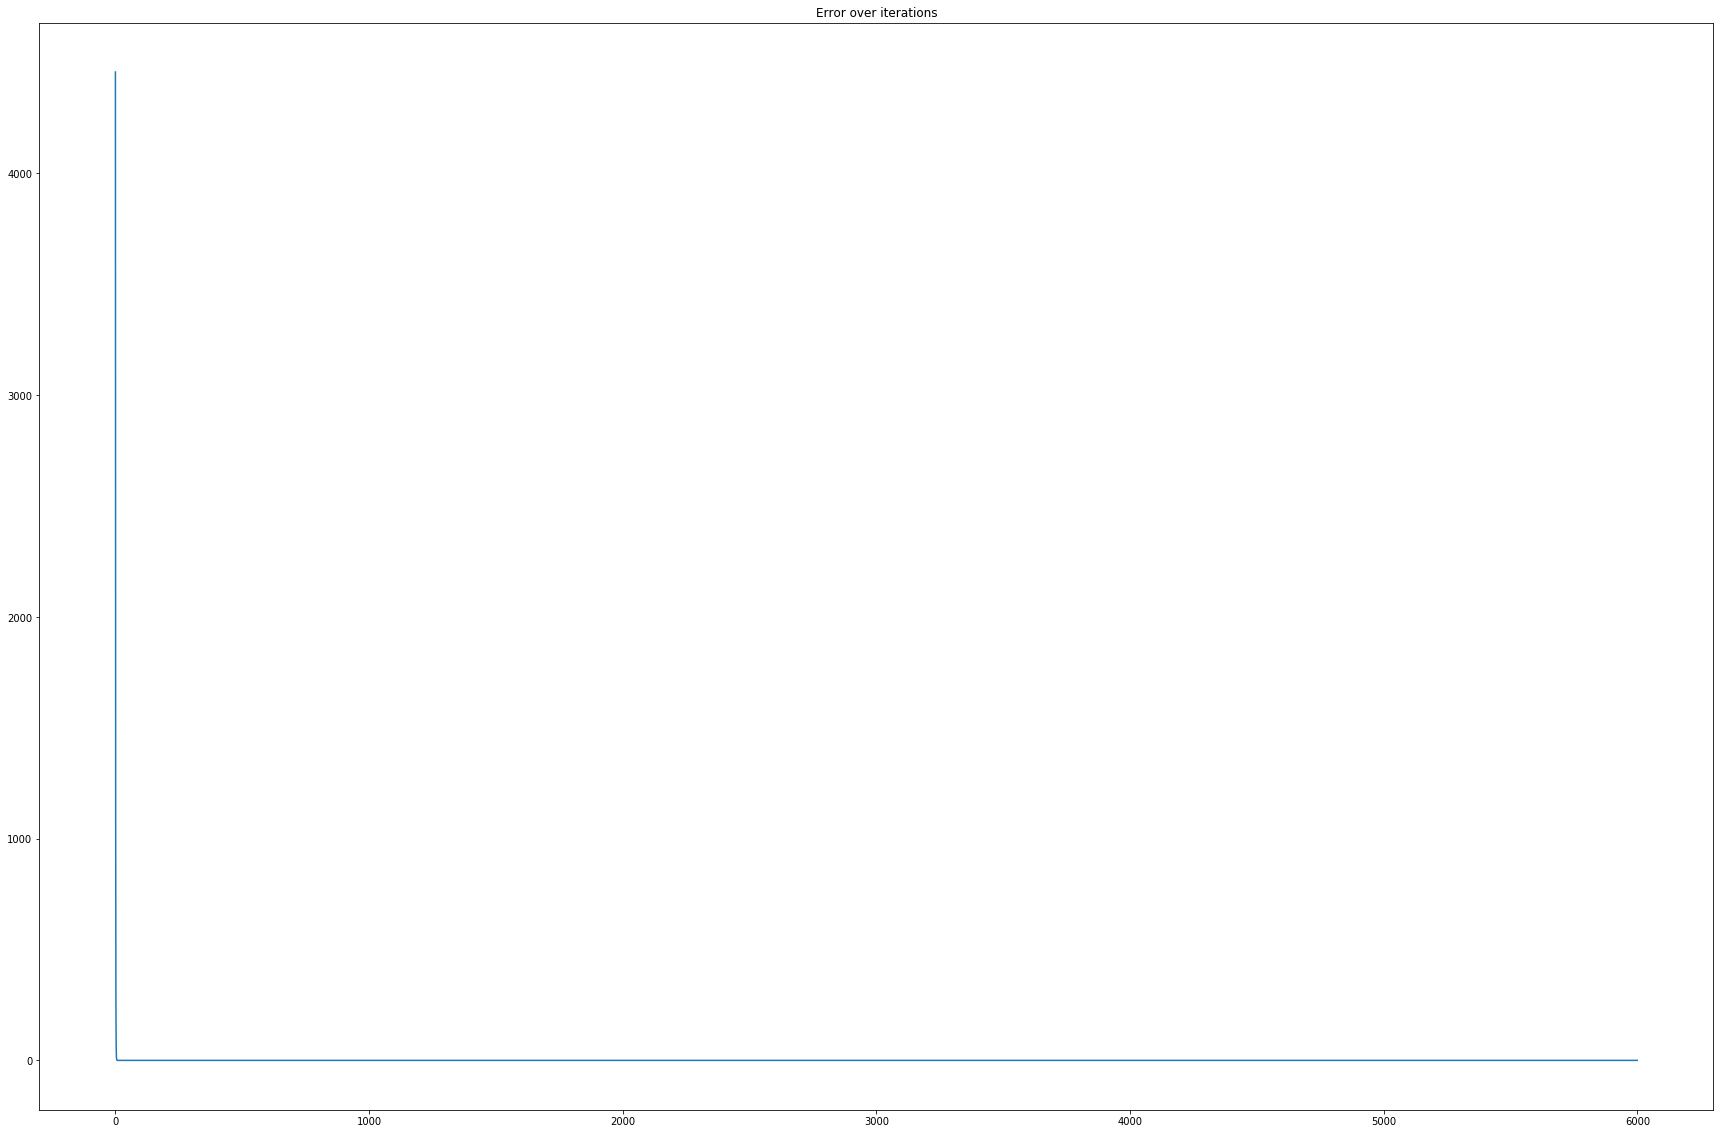

Pred:  [[3.45980679]]
Pred:(rounded)  [[3.]]
Labl:  3
[array([[1.07536812, 0.91353734, 0.55736399]])]


In [328]:
s = [2, 1]
a_f = [identity]

n = NeuralNetwork(s, a_f)

n.batch_training(t_e[0:60000], l_e[0:60000],
                 alpha = 0.0001, 
                 batch_size= 10, 
                 epochs = 1, 
                 overfit= False, 
                 vocal=False, 
                 display_signals = False,
                iters = 100000)

sig, d_sig = n.feed_forward(np.matrix([1, 2]).T)
print("Pred: ", sig[-1])
print("Pred:(rounded) ", np.round(sig[-1]))

print("Labl: ", 2 + 1)

print(n.weights)
        

        

Hmm... The addition certainly give the right integer answer, but the decimals seem to overshoot... It migh be that the bias complicated training as the weights only need to converge to 1, 1 in order for feed_forward to return 
     x1 * 1 + x2 * 1 = x1 + x2
Further experimentation is needed though, the bias should help learning, not combat it! A round should yield the right answer.

Now lets try one to one mapping (will most likely give similar results)

Weight before training:  [array([[0.02328741, 0.87255282]])]
input with 4:  [[0.96570247]]
input with 5:  [[0.98898988]]
input with 6:  [[1.01227729]]
input with -50:  [[-0.29181774]]
35.079595767146884 3.6484180231162344e-13


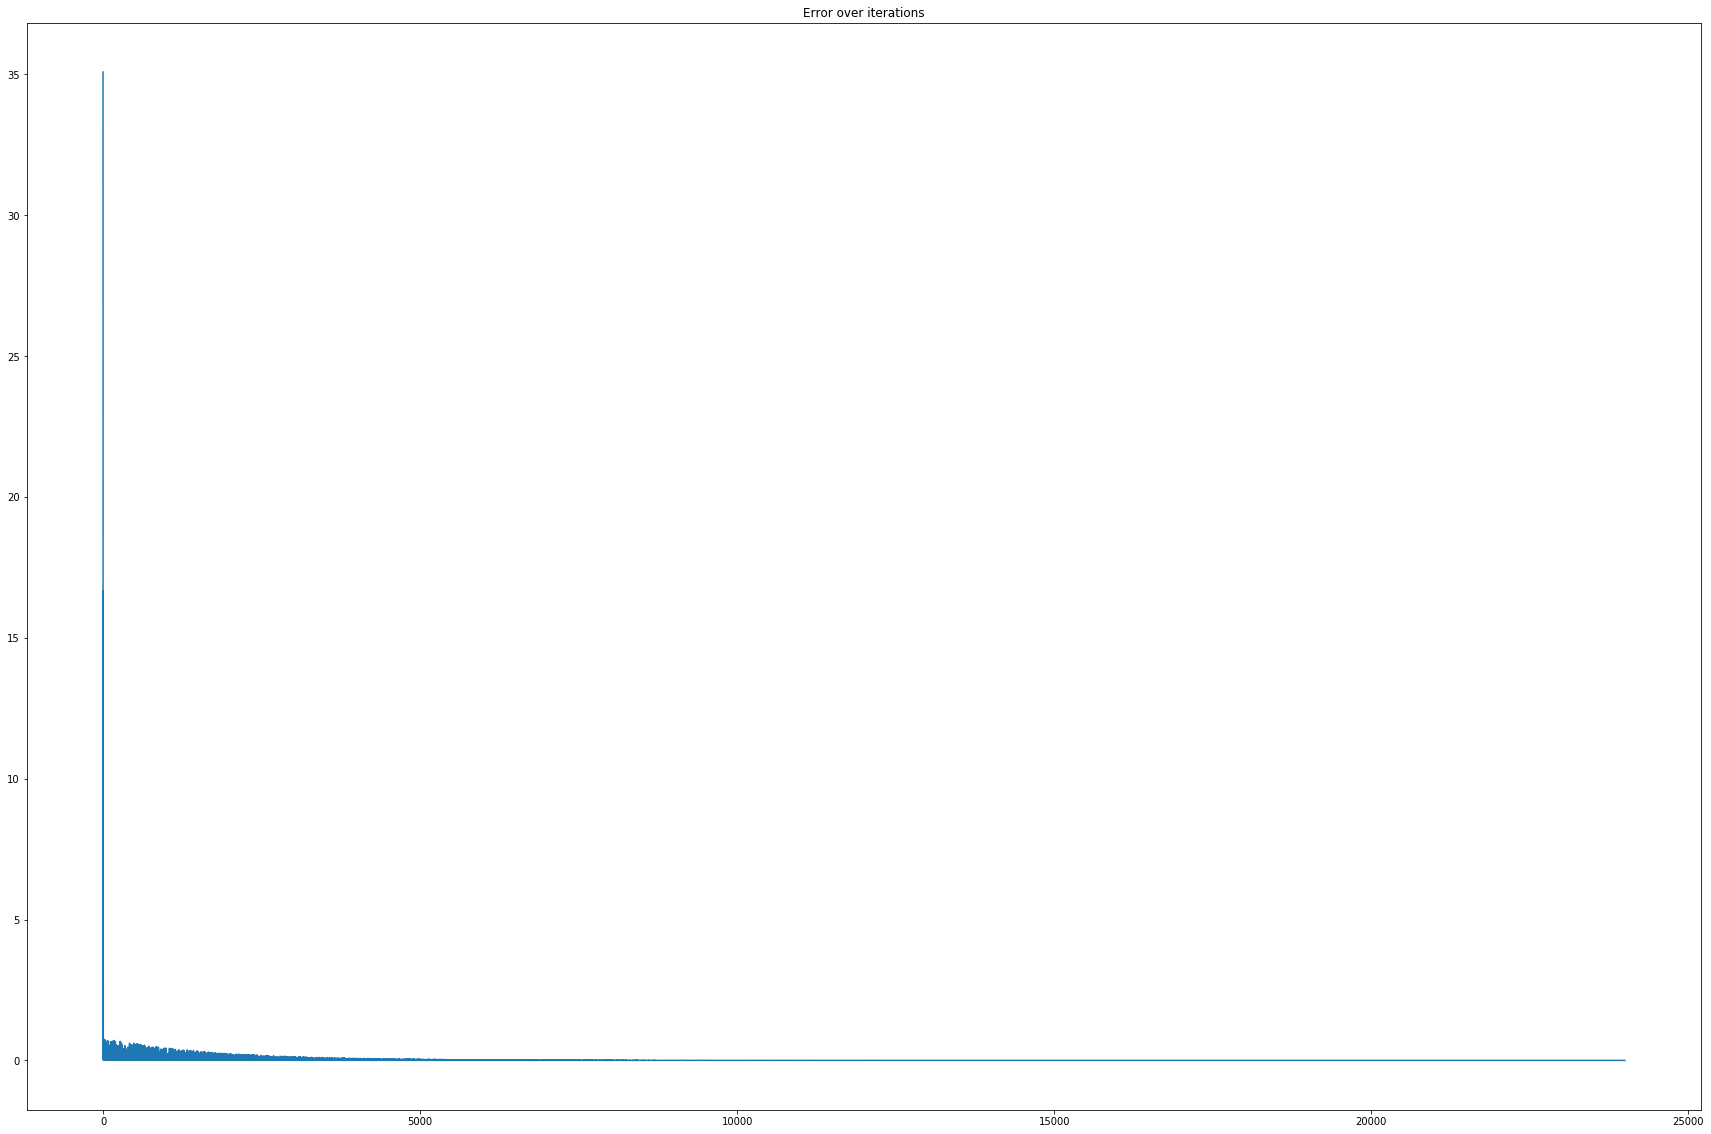


Weight after training:  [array([[0.99977616, 0.00566815]])]
input with 4:  [[4.00477278]]
input with 5:  [[5.00454894]]
input with 6:  [[6.0043251]]
input with -50:  [[-49.98313976]]
   Rounded signals:
input with 4:  [[4.]]
input with 5:  [[5.]]
input with 6:  [[6.]]
input with -50:  [[-50.]]


In [329]:

s = [1, 1]
a_f = [identity]

alpha = 0.001
epochs = 4
mini_batch_size = 10

n = NeuralNetwork(s, a_f)

# Dummy data
num_data = 60000
ex = np.random.random_sample(num_data) * 50

print("Weight before training: ", n.weights)

print("input with 4: ", n.feed_forward(np.matrix(4))[0][1])
print("input with 5: ", n.feed_forward(np.matrix(5))[0][1])
print("input with 6: ", n.feed_forward(np.matrix(6))[0][1])
print("input with -50: ", n.feed_forward(np.matrix(-50))[0][1])



error = n.batch_training(ex, ex, 
                         alpha = alpha, 
                         batch_size = mini_batch_size, 
                         epochs = epochs, 
                         overfit= False)



print()
print("Weight after training: ", n.weights)
print("input with 4: ", n.feed_forward(np.matrix(4))[0][1])
print("input with 5: ", n.feed_forward(np.matrix(5))[0][1])
print("input with 6: ", n.feed_forward(np.matrix(6))[0][1])
print("input with -50: ", n.feed_forward(np.matrix(-50))[0][1])
print("   Rounded signals:")
print("input with 4: ", np.round(n.feed_forward(np.matrix(4))[0][1]))
print("input with 5: ", np.round(n.feed_forward(np.matrix(5))[0][1]))
print("input with 6: ", np.round(n.feed_forward(np.matrix(6))[0][1]))
print("input with -50: ", np.round(n.feed_forward(np.matrix(-50))[0][1]))

This seems promising, the reason -50 cannot be predicted accurately is because of the bias added to the input signal during feed forwarding. The weights do however approach a satisfying value. The first value in the weight matrix(or in this case array) seem to approach 1 while the weight connected to the bias approaches 0. This will idealy result in a feed forward calculation of the form x * 1 + 1 * 0 = x, which is the desired behaviour in this case. Rounding the values however seem to give the right answer.

The results are however not as accurate as I had hoped, the best results only have a correctness to the third decimal number


## Mnist

This is the famous hand-written digits data, whrough my network I appear to achieve an accuracy of 95% on the test data.
The network consists of 2 weight matrices sized 500, 785 and 10, 501. Each layer is activated by the l_relu activation function.

In [ ]:
np.random.seed(0) 
NN = NeuralNetwork([784, 52**2, 10], [l_relu, l_relu])

num = 50000
    
NN.batch_training(training_examples[0:num], train_l_encoded[0:num],
                  valid_examples = validation_examples, valid_labels = validation_labels,
                  test_examples = test_examples, test_labels = test_l_encoded,
               epochs = 3, 
               alpha = 0.01,
               dropout = 0.4,
               batch_size = 10,
               reg_term = 0.001,
               vocal=True, 
               overfit = False,
               display_signals = True,
               display_freq = 1000)



With regularization and dropout the networks now takes longer to train, accuracy is lowered by rouhgly 8% from the non-regularized network on the same time.

Now let's see what the weights look like, we can plot their shape as images if we discard the bias weights

In [ ]:
for i in range(5):
    plt.imshow(NN.weights[0][i, :-1].reshape(img_dim))
    plt.show()

m = np.zeros_like(NN.weights[0][0])
for i in range(len(NN.weights[0])):
    m = np.add(m, NN.weights[0][i]/len(NN.weights[0]))
m = m[0:-1]

print("Summed weights: ")
plt.imshow(m.reshape(28, 28))
plt.show()

The reverse can be learned by feeding in the labels and predicting the example images, this is easily trained by increasing the epochs and reducing the amount of training examples, allowing the net to overfit.

Dropout helps in accelerating learning in this case, since it helps in avoiding overflow by reducing the summed signals.

Predictions for each kind of label is then showed below, introducing random noise to the input could increase the ways output can be shaped!

In [ ]:
# Can the reverse be learned? Probably not directly...
n = NeuralNetwork([10, 50**2, 784], [l_relu, l_relu])

num = 1000
n.batch_training(train_l_encoded[0:num],
                 lab_examples[0:num],
                 epochs = 5,
                 alpha = 0.0005,
                 dropout = 0.1,
                 batch_size = 10,
                 vocal = True,
                 overfit = False,
                 display_signals = True,
                 display_freq = 20)

In [ ]:
for i in range(10):
    s, d = n.feed_forward(one_hot_encode(i))
    
    plt.imshow(s[-1].reshape(28, 28))
    plt.show()

# Cifar dataset


In [ ]:


# Method and data taken from: http://www.cs.toronto.edu/~kriz/cifar.html

# Reference:
# Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
import pickle

file = open("cifar/data_batch_1", 'rb')
datadict = pickle.load(file,encoding='latin1')
file.close()
X = datadict["data"]
Y = datadict['labels']
X_R = []
X_G = []
X_B = []

Y_enc = []
for j in range(len(X)):
    X_R.append(normalize(X[j][0 : 32**2]))
    X_G.append(normalize(np.matrix(X[j][32**2 : 32**2 * 2])))
    X_B.append(normalize(np.matrix(X[j][32**2 * 2 : 32**2 * 3])))

for i in Y:

    Y_enc.append(one_hot_encode(i, size = 10))
    
print(Y_enc[0])

In [ ]:
# Needs to be tuned further to work appropriately
cifar_net = NeuralNetwork([32**2, 25**2, 20**2, 15**2, 10], [sigmoid, l_relu, l_relu, l_relu])
num = 9000
cifar_net.batch_training(X_R[0:num], Y_enc[0:num],
                         valid_examples = X_R[num:num+100], valid_labels=Y_enc[num:num+100],
                        epochs = 5,
                        alpha = 0.0008,
                        dropout = 0.1,
                        reg_term = 0.1,
                        batch_size = 10,
                        vocal = True,
                        overfit = False,
                        display_signals = True,
                        display_freq = 200)

In [ ]:
c_net = NeuralNetwork([10, 20**2, 32**2], [sigmoid, l_relu])
num = 9000
c_net.batch_training(Y_enc, X_R,
                        epochs = 5,
                        alpha = 0.0003,
                        dropout = 0.3,
                        batch_size = 10,
                        vocal = True,
                        overfit = False,
                        display_signals = True,
                        display_freq = 100)

## Experimental

Can we train the middle layer without labels to predict the mnist data?

The idea is to create a network that reproduces the input data, in the process it will establish behaviour in the hidden layers. My hypothesis is that if the layer in the middle has 10 neurons, it should be possible to predict mnist by looking at the activations from this layer. By extension it should be possible to use this hidden layer as an input layer to produce an image of the given input

In [ ]:
np.random.seed(0) 
neural_net = NeuralNetwork([28**2, 20**2, 10, 20**2, 28**2], [l_relu, sigmoid, tanh, sigmoid])

num = 1000
   
neural_net.batch_training(training_examples[0:num], 
               lab_examples[0:num], 
               epochs = 5, 
               alpha = 0.001,
               dropout = 0.5,
               batch_size = 10, 
               vocal=True, 
               overfit = False,
                display_signals = True,
               display_freq = 50)

#neural_net.test(test_examples[0:100], lab_examples[0:100])



Takes some time to train and appears to produce too big an error to work, will need to test this further...

In [ ]:
for i in range(5):
    s, d = neural_net.feed_forward(test_examples[i])
    
    displayMe(s, np.sum(MSE(s[-1], test_examples)), neural_net.sizes)

While I believe dropout can still be used to make this experiment work, the 10-neuron layer still doesn't produce the desired result. As shown above, the middle 10-neuron layer has the third(indexed 2) neuron as the primary activation. The goal is to make that layer notice patterns dynamically, teaching itself the differences of the numbers in the process.

Defining dropout-rate layer-wise(as opposed by a singular dropout value for the whole network) might be a solution in this case as that would limit the amount of activations in each layer enforcing patterns in the process.